In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from re import search

# import tqdm in order to show a progress bar
from tqdm  import tqdm

# tensorflow and keras imports
import os
import warnings
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical

# import the libraries needed in order to handle the images
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import pathlib

# Confusion matrix
from sklearn.metrics import confusion_matrix

#from learntools.core import binder
#binder.bind(globals())
#from learntools.computer_vision.ex5 import *

# import the libraries needed for the files and directories
import glob
import shutil

from matplotlib import gridspec

# import the library used to create the datasets using the directories
#from tensorflow.keras.preprocessing import image_dataset_from_directory


import cv2
from random import shuffle
#plt.style.use('fivethirtyeight')

print("Setup completed")

Using TensorFlow backend.


Setup completed


In [2]:
IMAGE_SIZE = 128
CLASSES = ['0', '1', '2', '3']
LR = 1e-3
DIR = r'D:\Python37\Projects\Foliar diseases in apple trees\images'


        image_id  healthy  multiple_diseases  rust  scab
0        Train_0        0                  0     0     1
1        Train_1        0                  1     0     0
2        Train_2        1                  0     0     0
3        Train_3        0                  0     1     0
4        Train_4        1                  0     0     0
...          ...      ...                ...   ...   ...
1816  Train_1816        0                  0     0     1
1817  Train_1817        1                  0     0     0
1818  Train_1818        1                  0     0     0
1819  Train_1819        0                  0     1     0
1820  Train_1820        0                  0     0     1

[1821 rows x 5 columns]
       image_id
0        Test_0
1        Test_1
2        Test_2
3        Test_3
4        Test_4
...         ...
1816  Test_1816
1817  Test_1817
1818  Test_1818
1819  Test_1819
1820  Test_1820

[1821 rows x 1 columns]


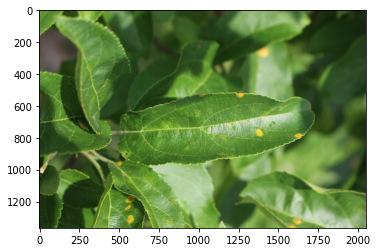

In [3]:
train_dataset = pd.read_csv(r'D:\Python37\Projects\Foliar diseases in apple trees\train.csv')
print(train_dataset)
test_dataset = pd.read_csv(r'D:\Python37\Projects\Foliar diseases in apple trees\test.csv')
print(test_dataset)

# Convert the first image into an array
image = Image.open('D:\Python37\Projects\Foliar diseases in apple trees\images\Test_0.jpg');
#print(np.asarray(image))
img_open = plt.imshow(image)

In [4]:
print(train_dataset.head())

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0


In [5]:
train_dataset['image_id'] = train_dataset['image_id'] + '.jpg'
print(train_dataset.shape)
print(train_dataset)
#define the class names
class_names = train_dataset.loc[:, 'healthy':].columns
print(class_names)

(1821, 5)
            image_id  healthy  multiple_diseases  rust  scab
0        Train_0.jpg        0                  0     0     1
1        Train_1.jpg        0                  1     0     0
2        Train_2.jpg        1                  0     0     0
3        Train_3.jpg        0                  0     1     0
4        Train_4.jpg        1                  0     0     0
...              ...      ...                ...   ...   ...
1816  Train_1816.jpg        0                  0     0     1
1817  Train_1817.jpg        1                  0     0     0
1818  Train_1818.jpg        1                  0     0     0
1819  Train_1819.jpg        0                  0     1     0
1820  Train_1820.jpg        0                  0     0     1

[1821 rows x 5 columns]
Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


In [6]:
counter = 0
train_dataset['label'] = 0
for name in class_names:
    train_dataset['label'] = train_dataset['label'] + train_dataset[name] * counter
    counter = counter + 1
    
print(train_dataset)

            image_id  healthy  multiple_diseases  rust  scab  label
0        Train_0.jpg        0                  0     0     1      3
1        Train_1.jpg        0                  1     0     0      1
2        Train_2.jpg        1                  0     0     0      0
3        Train_3.jpg        0                  0     1     0      2
4        Train_4.jpg        1                  0     0     0      0
...              ...      ...                ...   ...   ...    ...
1816  Train_1816.jpg        0                  0     0     1      3
1817  Train_1817.jpg        1                  0     0     0      0
1818  Train_1818.jpg        1                  0     0     0      0
1819  Train_1819.jpg        0                  0     1     0      2
1820  Train_1820.jpg        0                  0     0     1      3

[1821 rows x 6 columns]


# Prepare for training

In [7]:
def get_label_img(img):
    if search("Train", img):
        label = train_dataset.loc[train_dataset["image_id"] == img]['label']
        return label
    

In [8]:
train_dataset

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0.jpg,0,0,0,1,3
1,Train_1.jpg,0,1,0,0,1
2,Train_2.jpg,1,0,0,0,0
3,Train_3.jpg,0,0,1,0,2
4,Train_4.jpg,1,0,0,0,0
...,...,...,...,...,...,...
1816,Train_1816.jpg,0,0,0,1,3
1817,Train_1817.jpg,1,0,0,0,0
1818,Train_1818.jpg,1,0,0,0,0
1819,Train_1819.jpg,0,0,1,0,2


In [9]:
import natsort
def create_train_data():
    images = natsort.natsorted(os.listdir(DIR))
    for img in tqdm(images):
        label = get_label_img(img)
        path = os.path.join(DIR, img)
        #image_name = img
        #img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMAGE_SIZE, IMAGE_SIZE))
        
        if search("Train", img):
            if int(img.split("_")[1].split(".")[0])  and label.item() == 0 :
                shutil.copy(path, r'D:\Python37\Projects\Foliar diseases in apple trees\images\train_images/healthy')
            elif int(img.split("_")[1].split(".")[0])  and label.item() == 1:
                shutil.copy(path, r'D:\Python37\Projects\Foliar diseases in apple trees\images/train_images/multiple_diseases')
            elif int(img.split("_")[1].split(".")[0])  and label.item() == 2:
                shutil.copy(path, r'D:\Python37\Projects\Foliar diseases in apple trees\images\train_images/rust')
            elif int(img.split("_")[1].split(".")[0])  and label.item() == 3:
                shutil.copy(path, r'D:\Python37\Projects\Foliar diseases in apple trees\images\train_images/scab')

                
        elif search("Test", img):
            shutil.copy(path, r'D:\Python37\Projects\Foliar diseases in apple trees\images\test_images/') 

In [10]:
shutil.os.mkdir(r'D:\Python37\Projects\Foliar diseases in apple trees\images\train_images/')
shutil.os.mkdir(r'D:\Python37\Projects\Foliar diseases in apple trees\images\test_images/')
shutil.os.mkdir(r'D:\Python37\Projects\Foliar diseases in apple trees\images\train_images\healthy/')
shutil.os.mkdir(r'D:\Python37\Projects\Foliar diseases in apple trees\images\train_images\multiple_diseases/')
shutil.os.mkdir(r'D:\Python37\Projects\Foliar diseases in apple trees\images\train_images\rust/')
shutil.os.mkdir(r'D:\Python37\Projects\Foliar diseases in apple trees\images\train_images\scab/')
train_data = create_train_data()

100%|█████████████████████████████████████████████████████████████████████████████| 3644/3644 [00:12<00:00, 297.13it/s]


# Models

In [11]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [12]:
# Convolutional Neural Network

# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing.image import 

In [13]:
tf.__version__

'2.2.0'

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12680117070024330287
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3574268787932732776
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2147483648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16708729360829432720
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8102862974766711427
physical_device_desc: "device: XLA_GPU device"
]


In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Part 1 - Data Preprocessing

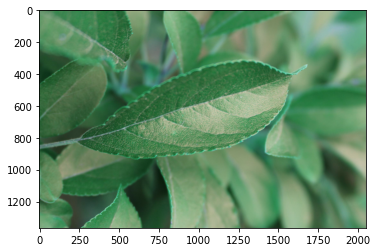

In [18]:
DATADIR = r"D:\Python37\Projects\Foliar diseases in apple trees\images\train_images/"

CATEGORIES = ["healthy", "multiple_diseases","rust","scab"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.COLOR_BGR2RGB)  # convert to array
        plt.imshow(img_array)  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

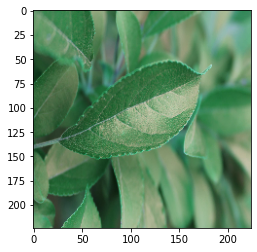

In [19]:
IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [22]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    r'D:\Python37\Projects\Foliar diseases in apple trees\images\train_images',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
   r'D:\Python37\Projects\Foliar diseases in apple trees\images\train_images', # same directory as training data
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 1457 images belonging to 4 classes.
Found 363 images belonging to 4 classes.


In [23]:
from tensorflow.keras.layers import Conv2D

In [24]:
Conv2D(filters=32,padding="same",kernel_size=3)

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [26]:
# define cnn model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))
# compile model
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    name='Adam'
)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 28, 28, 128)       8

In [27]:
                   
checkpoint = ModelCheckpoint("D:\Python37\Projects\Foliar diseases in apple trees/apple-224.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [28]:
# Part 3 - Training the CNN

# Compiling the CNN
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
history=model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 16,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 16,
    callbacks=callbacks,
    epochs = 30)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
91/91 [==============================] - ETA: 0s - loss: 1.5294 - accuracy: 0.3220
Epoch 00001: val_loss improved from inf to 1.27620, saving model to D:\Python37\Projects\Foliar diseases in apple trees/apple-224.h5
91/91 [==============================] - 64s 708ms/step - loss: 1.5294 - accuracy: 0.3220 - val_loss: 1.2762 - val_accuracy: 0.3807
Epoch 2/30
91/91 [==============================] - ETA: 0s - loss: 1.2687 - accuracy: 0.3303
Epoch 00002: val_loss improved from 1.27620 to 1.24432, saving model to D:\Python37\Projects\Foliar diseases in apple trees/apple-224.h5
91/91 [==============================] - 51s 558ms/step - loss: 1.2687 - accuracy: 0.3303 - val_loss: 1.2443 - val_accuracy: 0.3381
Epoch 3/30
91/91 [==============================] - ETA: 0s - loss: 1.2432 - accuracy: 0.3331
Epoch 00003: val_loss improved from 1.24432 to 1.23874, saving model to D:\Python37\Projects\Foliar diseases

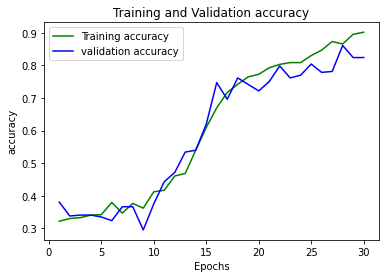

In [31]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

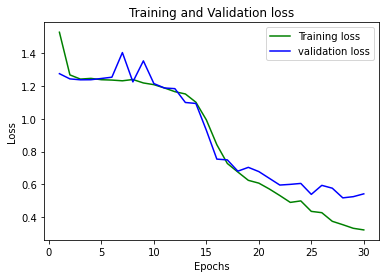

In [33]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
# save it as a h5 file

#model.save(r'D:\Python37\Projects\Foliar diseases in apple trees\apple-2.h5')

In [35]:
from tensorflow.keras.models import load_model
 
# load model
#model = load_model(r'D:\Python37\Projects\Foliar diseases in apple trees\apple-3.h5')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 28, 28, 128)       8

# Part 4 - Making a single prediction

In [39]:
test_image_single=(r'D:\Python37\Projects\Foliar diseases in apple trees\images\Train_2.jpg')

[0]


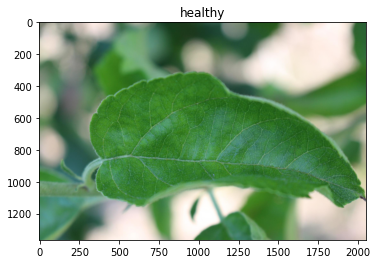

In [40]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img(test_image_single, target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(np.argmax(result,axis=1))
categories = ['healthy', 'multiple diseases', 'rust', 'scab']
categories[np.argmax(result)]
image_h = Image.open(test_image_single)
img_h = plt.imshow(image_h)
plt.title(categories[int(np.argmax(result,axis=1))])
plt.show()